# CS 269Q: Final Project - QAOA on MIS
## Part 2: Using Grid Search 

__Note:__ Part 1: Using Classical Optimizer is documented on another notebook.

__GOAL:__ Generate random MIS instances for simulation on the QVM and the QPU. Benchmark against various noise models.

In [1]:
from pyquil import Program
from pyquil.gates import RESET
from pyquil.paulis import sZ, sX, sI, exponentiate_commuting_pauli_sum

def mis_ansatz(betas, gammas):
    pq = Program(RESET())
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    pq.measure_all()
    return pq

In [2]:
from pyquil.gates import I, X
from pyquil.api import WavefunctionSimulator

def bit_energy(bitstring, h_cost):
    size = len(bitstring)
    pq = Program()
    for i in range(size):
        if bitstring[i] == 0:
            pq += Program(I(i))
        elif bitstring[i] == 1:
            pq += Program(X(i))
    return np.real(WavefunctionSimulator().expectation(prep_prog = pq, pauli_terms = h_cost))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

def plot_landscape(landscape: np.ndarray, *, device: str, edges: List[Tuple[int, int]],
                   width: int, shots: int):
    max_x, max_y = (np.argmax(landscape) % width, np.argmax(landscape) // width)
    min_x, min_y = (np.argmin(landscape) % width, np.argmin(landscape) // width)
    plt.imshow(landscape, extent=[0, np.pi, np.pi, 0])
    plt.plot((max_x + 0.5) * np.pi / width, (max_y + 0.5) * np.pi / width, 'ro')
    plt.plot((min_x + 0.5) * np.pi / width, (min_y + 0.5) * np.pi / width, 'go')
    plt.colorbar()
    plt.xlabel('gamma (radians)')
    plt.ylabel('beta (radians)')
    plt.title(f'Max-Cut QAOA Landscape\n{device}\n{edges}\nwidth = {width} shots = {shots}')
    plt.show()

In [4]:
import itertools
from tqdm import tqdm
from pyquil.api import QPU, QuantumComputer

def run_mis_qaoa_landscape(qc: QuantumComputer, num_nodes, edge_list, delta, U, omega, width: int,
                              shots: int = 1000) -> np.ndarray:
   
    beta_lst = []
    gamma_lst = []
    costs = []
    angle_range = np.linspace(0, np.pi, width)
    landscape = list(itertools.product(angle_range, angle_range))
    for lst in tqdm(landscape):
        half = int(len(lst)/2)
        betas, gammas = lst[:half], lst[half:]
        
        p = mis_ansatz(betas, gammas)
        p.wrap_in_numshots_loop(shots)
        
        binary = qc.compile(p) if isinstance(qc.qam, QPU) else p
        bitstrings = qvm.run(binary)
        energy = np.mean([bit_energy(b, h_cost) for b in bitstrings])
        costs.append(energy)
        beta_lst.append(betas)
        gamma_lst.append(gammas)
        
    return costs, beta_lst, gamma_lst, np.array(costs).reshape(width, width)

In [5]:
def elist_from_math(string):
    string = string.replace(',','), (')
    string = string.replace(' <->',',')
    return eval('(' + string + ')')

In [6]:
def get_hamil(num_nodes, edge_list, delta, U, omega):
    nodes = list(range(0,num_nodes))
    edges = [(i-1,j-1) for i,j in edge_list]
    h_cost = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    h_driver = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    return h_cost, h_driver

In [7]:
def optimal_params(costs, beta, gamma):
    min_cost = costs[np.argmin(costs)]
    beta = beta[np.argmin(costs)]
    gamma = gamma[np.argmin(costs)]
    print("The minimum cost is:", min_cost)
    print("The optimal beta value(s):",beta)
    print("The optimal gamma value(s):",gamma)
    return beta, gamma

In [8]:
from pyquil import get_qc

# qpu = get_qc('Aspen-3-3Q-B')  # edit as necessary
qvm = get_qc('5q-qvm')  # edit as necessary

In [9]:
string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 3, 2 <-> 4, 2 <-> 5, 3 <-> 4, 4 <-> 5'
elist = elist_from_math(string)

width = 10
shots = 100
num_nodes = 5  # edit as necessary
delta = 1
U = 1.5
omega = 0.5

h_cost, h_driver = get_hamil(num_nodes, elist, delta, U, omega)

In [ ]:
costs, beta, gamma, plot = run_mis_qaoa_landscape(qvm, num_nodes, elist, delta, U, omega, width, shots)
optimal_params(costs, beta, gamma)
plot_landscape(plot, device=qvm.name, edges=elist, width=width, shots=shots)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:57<00:00,  1.73s/it]


The minimum cost is: -0.565
The optimal beta value(s): (1.0471975511965976,)
The optimal gamma value(s): (0.3490658503988659,)


In [ ]:
# costs, beta, gamma, plot = run_mis_qaoa_landscape(qpu, num_nodes, elist, delta, U, omega, width, shots)
# optimal_params(costs, beta, gamma)
# plot_landscape(plot, device=qvm.name, edges=elist, width=width, shots=shots)

In [99]:
optimal_params(costs, betaa, gamma)

The minimum cost is: -0.5
The optimal beta value(s): (1.0471975511965976,)
The optimal gamma value(s): (0.0,)


((1.0471975511965976,), (0.0,))

In [90]:
p = Program(RESET())
p += mis_ansatz([1.0471975511965976],[0])
p.wrap_in_numshots_loop(100)
binary = qvm.compile(p) if isinstance(qvm.qam, QPU) else p
bitstrings = qvm.run(binary)
energy = np.mean([bit_energy(b, h_cost) for b in bitstrings])
print(energy)

-0.43


In [33]:
angle_range = np.linspace(0, np.pi, width)
landscape = list(itertools.product(angle_range, angle_range))
for lst in landscape:
    print(lst)

(0.0, 0.0)
(0.0, 0.3490658503988659)
(0.0, 0.6981317007977318)
(0.0, 1.0471975511965976)
(0.0, 1.3962634015954636)
(0.0, 1.7453292519943295)
(0.0, 2.0943951023931953)
(0.0, 2.443460952792061)
(0.0, 2.792526803190927)
(0.0, 3.141592653589793)
(0.3490658503988659, 0.0)
(0.3490658503988659, 0.3490658503988659)
(0.3490658503988659, 0.6981317007977318)
(0.3490658503988659, 1.0471975511965976)
(0.3490658503988659, 1.3962634015954636)
(0.3490658503988659, 1.7453292519943295)
(0.3490658503988659, 2.0943951023931953)
(0.3490658503988659, 2.443460952792061)
(0.3490658503988659, 2.792526803190927)
(0.3490658503988659, 3.141592653589793)
(0.6981317007977318, 0.0)
(0.6981317007977318, 0.3490658503988659)
(0.6981317007977318, 0.6981317007977318)
(0.6981317007977318, 1.0471975511965976)
(0.6981317007977318, 1.3962634015954636)
(0.6981317007977318, 1.7453292519943295)
(0.6981317007977318, 2.0943951023931953)
(0.6981317007977318, 2.443460952792061)
(0.6981317007977318, 2.792526803190927)
(0.69813170079

In [ ]:
def mis_qaoa_program(num_nodes, edge_list, delta, U, omega, betas, gammas) -> Program:
    nodes = list(range(0,num_nodes))
    edges = [(i-1,j-1) for i,j in edge_list]
    cost_ham = -0.5* delta * sum((sI(i) - sZ(i)) for i in nodes) + 0.25 * U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)
    driver_ham = omega*sum(sX(i) for i in nodes) + 0.25*U * sum((sI(i) - sZ(i))*(sI(j) - sZ(j)) for i, j in edges)

    p = Program(RESET())
    ro = p.declare('ro', 'BIT', len(nodes))

    # p.inst(H(qubit) for qubit in list(nodes))
    # p.inst(exponential_map(term)(gamma) for term in cost_ham)
    # p.inst(exponential_map(term)(beta) for term in driver_ham)
    
    p += [exponentiate_commuting_pauli_sum(cost_ham)(g) + exponentiate_commuting_pauli_sum(driver_ham)(b) 
                for g, b in zip(gammas, betas)]

    #p.inst(MEASURE(qubit, ro[idx]) for idx, qubit in enumerate(list(nodes)))
    return p

In [18]:
x = np.asarray([2,4,6,2])

In [19]:
x.reshape(2,2)

array([[2, 4],
       [6, 2]])

  0%|                                                                                           | 0/81 [00:00<?, ?it/s]

(0.0, 0.0, 0.0, 0.0)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


  1%|█                                                                                  | 1/81 [00:00<00:24,  3.29it/s]

(0.0, 0.0, 0.0, 1.5707963267948966)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


  2%|██                                                                                 | 2/81 [00:00<00:22,  3.45it/s]

(0.0, 0.0, 0.0, 3.141592653589793)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


  4%|███                                                                                | 3/81 [00:00<00:21,  3.63it/s]

(0.0, 0.0, 1.5707963267948966, 0.0)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


  5%|████                                                                               | 4/81 [00:01<00:20,  3.69it/s]

(0.0, 0.0, 1.5707963267948966, 1.5707963267948966)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


  6%|█████                                                                              | 5/81 [00:01<00:19,  3.82it/s]

(0.0, 0.0, 1.5707963267948966, 3.141592653589793)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


  7%|██████▏                                                                            | 6/81 [00:01<00:19,  3.78it/s]

(0.0, 0.0, 3.141592653589793, 0.0)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


  9%|███████▏                                                                           | 7/81 [00:01<00:19,  3.85it/s]

(0.0, 0.0, 3.141592653589793, 1.5707963267948966)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


 10%|████████▏                                                                          | 8/81 [00:02<00:18,  3.94it/s]

(0.0, 0.0, 3.141592653589793, 3.141592653589793)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


 11%|█████████▏                                                                         | 9/81 [00:02<00:18,  3.99it/s]

(0.0, 1.5707963267948966, 0.0, 0.0)
[[1 1 1 1 0]
 [0 1 1 1 0]
 [0 0 1 0 0]
 [0 0 1 1 0]
 [1 1 0 1 1]
 [0 1 1 1 1]
 [1 0 1 1 1]
 [0 0 1 1 0]
 [0 0 1 0 0]
 [1 1 1 1 1]]


 12%|██████████                                                                        | 10/81 [00:02<00:17,  4.04it/s]

(0.0, 1.5707963267948966, 0.0, 1.5707963267948966)
[[1 0 1 1 0]
 [0 0 1 0 1]
 [1 1 1 0 1]
 [1 0 1 0 1]
 [1 1 0 0 0]
 [0 0 1 1 0]
 [1 1 1 1 0]
 [0 1 1 1 1]
 [0 1 1 0 1]
 [0 0 0 1 0]]


 14%|███████████▏                                                                      | 11/81 [00:02<00:17,  3.92it/s]

(0.0, 1.5707963267948966, 0.0, 3.141592653589793)
[[0 1 0 1 1]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 1 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 1 0 0 1]
 [1 0 1 0 1]
 [1 0 0 1 1]]


 15%|████████████▏                                                                     | 12/81 [00:03<00:17,  4.01it/s]

(0.0, 1.5707963267948966, 1.5707963267948966, 0.0)
[[1 1 1 0 1]
 [1 1 1 1 1]
 [1 0 0 0 0]
 [0 1 1 1 1]
 [1 0 0 1 0]
 [1 1 0 0 1]
 [0 0 1 1 0]
 [1 0 1 0 1]
 [1 1 1 1 0]
 [0 1 0 0 0]]


 16%|█████████████▏                                                                    | 13/81 [00:03<00:18,  3.73it/s]

(0.0, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966)
[[1 1 0 1 1]
 [0 0 1 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [1 0 0 1 1]
 [0 0 1 0 0]
 [1 0 0 0 0]
 [1 0 1 0 0]
 [0 0 0 0 1]
 [0 0 1 0 1]]


 17%|██████████████▏                                                                   | 14/81 [00:03<00:20,  3.32it/s]

(0.0, 1.5707963267948966, 1.5707963267948966, 3.141592653589793)
[[0 1 1 0 0]
 [1 1 0 1 0]
 [1 0 1 0 1]
 [1 0 1 1 0]
 [0 1 1 1 1]
 [0 1 1 1 1]
 [0 1 1 0 0]
 [1 0 1 0 0]
 [1 1 0 0 1]
 [0 1 1 0 0]]


 19%|███████████████▏                                                                  | 15/81 [00:04<00:22,  2.98it/s]

(0.0, 1.5707963267948966, 3.141592653589793, 0.0)
[[1 0 0 0 1]
 [0 0 1 0 1]
 [0 0 1 0 0]
 [1 0 1 1 0]
 [0 0 0 1 1]
 [0 1 0 0 0]
 [1 1 1 1 1]
 [1 0 1 1 0]
 [1 1 1 0 0]
 [0 1 0 1 0]]


 20%|████████████████▏                                                                 | 16/81 [00:04<00:22,  2.85it/s]

(0.0, 1.5707963267948966, 3.141592653589793, 1.5707963267948966)
[[1 0 1 0 1]
 [1 1 1 1 1]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [0 1 1 0 0]
 [1 1 0 1 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [1 0 0 1 0]]


 21%|█████████████████▏                                                                | 17/81 [00:04<00:21,  2.98it/s]

(0.0, 1.5707963267948966, 3.141592653589793, 3.141592653589793)
[[0 0 0 0 0]
 [0 1 0 0 1]
 [1 0 0 0 1]
 [0 1 1 1 1]
 [1 1 0 1 1]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [1 0 1 1 1]
 [0 0 0 0 1]
 [0 0 1 1 0]]


 22%|██████████████████▏                                                               | 18/81 [00:05<00:20,  3.05it/s]

(0.0, 3.141592653589793, 0.0, 0.0)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 23%|███████████████████▏                                                              | 19/81 [00:05<00:19,  3.19it/s]

(0.0, 3.141592653589793, 0.0, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 25%|████████████████████▏                                                             | 20/81 [00:05<00:17,  3.43it/s]

(0.0, 3.141592653589793, 0.0, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 26%|█████████████████████▎                                                            | 21/81 [00:05<00:16,  3.62it/s]

(0.0, 3.141592653589793, 1.5707963267948966, 0.0)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 27%|██████████████████████▎                                                           | 22/81 [00:06<00:15,  3.80it/s]

(0.0, 3.141592653589793, 1.5707963267948966, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 28%|███████████████████████▎                                                          | 23/81 [00:06<00:14,  3.91it/s]

(0.0, 3.141592653589793, 1.5707963267948966, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 30%|████████████████████████▎                                                         | 24/81 [00:06<00:14,  4.06it/s]

(0.0, 3.141592653589793, 3.141592653589793, 0.0)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 31%|█████████████████████████▎                                                        | 25/81 [00:06<00:13,  4.03it/s]

(0.0, 3.141592653589793, 3.141592653589793, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 32%|██████████████████████████▎                                                       | 26/81 [00:07<00:13,  4.01it/s]

(0.0, 3.141592653589793, 3.141592653589793, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 33%|███████████████████████████▎                                                      | 27/81 [00:07<00:13,  4.00it/s]

(1.5707963267948966, 0.0, 0.0, 0.0)
[[0 0 1 0 1]
 [1 0 0 1 0]
 [1 1 0 0 0]
 [0 1 1 0 0]
 [1 0 0 1 1]
 [0 1 0 0 0]
 [1 0 0 0 0]
 [1 0 0 1 1]
 [1 1 0 0 0]
 [0 0 1 1 1]]


 35%|████████████████████████████▎                                                     | 28/81 [00:07<00:14,  3.59it/s]

(1.5707963267948966, 0.0, 0.0, 1.5707963267948966)
[[0 1 1 1 1]
 [1 0 0 0 1]
 [1 0 1 1 0]
 [0 0 0 0 1]
 [1 0 0 1 0]
 [1 0 0 1 1]
 [1 1 0 1 1]
 [0 1 0 0 1]
 [0 0 0 0 1]
 [1 1 1 1 1]]


 36%|█████████████████████████████▎                                                    | 29/81 [00:08<00:15,  3.25it/s]

(1.5707963267948966, 0.0, 0.0, 3.141592653589793)
[[1 0 0 0 0]
 [1 1 0 1 1]
 [1 0 0 0 0]
 [0 1 1 1 0]
 [0 0 1 0 0]
 [0 1 1 0 0]
 [0 1 0 0 1]
 [1 0 1 1 0]
 [0 0 0 1 1]
 [0 1 0 0 0]]


 37%|██████████████████████████████▎                                                   | 30/81 [00:08<00:15,  3.25it/s]

(1.5707963267948966, 0.0, 1.5707963267948966, 0.0)
[[0 1 1 1 1]
 [1 1 0 1 1]
 [0 0 0 1 1]
 [1 0 0 1 1]
 [0 1 0 1 0]
 [0 0 0 1 0]
 [1 0 0 0 1]
 [0 1 0 0 1]
 [0 1 1 0 0]
 [1 1 1 0 1]]


 38%|███████████████████████████████▍                                                  | 31/81 [00:08<00:15,  3.20it/s]

(1.5707963267948966, 0.0, 1.5707963267948966, 1.5707963267948966)
[[1 0 0 0 1]
 [0 0 1 0 0]
 [1 1 0 0 1]
 [1 0 0 0 0]
 [0 0 1 0 1]
 [0 1 1 1 1]
 [1 0 0 1 0]
 [1 1 0 0 1]
 [0 0 0 0 1]
 [0 0 1 0 1]]


 40%|████████████████████████████████▍                                                 | 32/81 [00:09<00:15,  3.25it/s]

(1.5707963267948966, 0.0, 1.5707963267948966, 3.141592653589793)
[[0 1 1 1 1]
 [0 0 1 0 1]
 [0 1 0 0 0]
 [0 1 0 1 0]
 [1 1 0 0 1]
 [0 1 1 1 0]
 [1 0 0 1 1]
 [1 0 1 0 0]
 [1 0 1 0 1]
 [0 0 0 1 1]]


 41%|█████████████████████████████████▍                                                | 33/81 [00:09<00:14,  3.32it/s]

(1.5707963267948966, 0.0, 3.141592653589793, 0.0)
[[1 0 1 0 1]
 [0 1 1 0 1]
 [0 1 1 1 0]
 [0 1 1 1 0]
 [0 1 1 0 0]
 [0 0 0 0 0]
 [0 1 1 0 1]
 [0 0 0 0 1]
 [0 1 0 1 0]
 [0 1 0 1 0]]


 42%|██████████████████████████████████▍                                               | 34/81 [00:09<00:13,  3.44it/s]

(1.5707963267948966, 0.0, 3.141592653589793, 1.5707963267948966)
[[1 0 1 0 1]
 [0 1 1 0 1]
 [1 0 0 1 1]
 [0 0 1 1 1]
 [1 0 0 1 0]
 [1 1 0 0 0]
 [1 1 0 0 0]
 [1 1 1 0 1]
 [0 1 0 1 0]
 [0 1 1 0 1]]


 43%|███████████████████████████████████▍                                              | 35/81 [00:09<00:12,  3.62it/s]

(1.5707963267948966, 0.0, 3.141592653589793, 3.141592653589793)
[[0 1 1 1 1]
 [0 1 1 1 0]
 [1 0 0 0 1]
 [1 1 0 0 0]
 [1 0 1 0 1]
 [0 1 0 0 1]
 [0 1 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 1]
 [1 1 1 1 1]]


 44%|████████████████████████████████████▍                                             | 36/81 [00:10<00:11,  3.77it/s]

(1.5707963267948966, 1.5707963267948966, 0.0, 0.0)
[[0 0 0 0 0]
 [1 1 1 1 1]
 [0 0 0 0 0]
 [1 1 0 1 0]
 [0 0 0 0 1]
 [1 1 1 0 1]
 [1 1 0 1 0]
 [0 0 0 0 0]
 [0 0 1 0 1]
 [0 1 0 1 1]]


 46%|█████████████████████████████████████▍                                            | 37/81 [00:10<00:11,  3.81it/s]

(1.5707963267948966, 1.5707963267948966, 0.0, 1.5707963267948966)
[[1 1 0 1 0]
 [1 1 0 1 0]
 [0 1 1 1 0]
 [0 0 0 0 0]
 [1 1 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [1 1 1 1 0]
 [1 1 0 1 0]]


 47%|██████████████████████████████████████▍                                           | 38/81 [00:10<00:11,  3.64it/s]

(1.5707963267948966, 1.5707963267948966, 0.0, 3.141592653589793)
[[1 1 1 1 1]
 [0 0 0 0 0]
 [1 0 0 0 0]
 [0 0 0 0 0]
 [1 1 1 1 0]
 [1 0 0 0 0]
 [1 0 1 0 1]
 [1 1 0 0 0]
 [1 1 1 0 0]
 [0 0 0 0 0]]


 48%|███████████████████████████████████████▍                                          | 39/81 [00:10<00:11,  3.54it/s]

(1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 0.0)
[[1 1 0 1 0]
 [1 1 0 1 1]
 [1 1 0 1 0]
 [1 0 1 0 1]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 0 0 0]
 [1 1 0 1 1]
 [0 0 1 0 1]
 [0 0 0 0 0]]


 49%|████████████████████████████████████████▍                                         | 40/81 [00:11<00:11,  3.45it/s]

(1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 0]
 [0 0 0 0 0]
 [0 0 1 0 1]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [1 1 1 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


 51%|█████████████████████████████████████████▌                                        | 41/81 [00:11<00:11,  3.40it/s]

(1.5707963267948966, 1.5707963267948966, 1.5707963267948966, 3.141592653589793)
[[1 1 0 1 1]
 [1 1 1 1 1]
 [1 1 0 1 1]
 [0 0 0 0 0]
 [1 0 1 1 1]
 [0 0 1 1 1]
 [0 1 1 1 1]
 [1 0 0 1 1]
 [0 0 0 1 0]
 [1 1 0 1 1]]


 52%|██████████████████████████████████████████▌                                       | 42/81 [00:11<00:11,  3.37it/s]

(1.5707963267948966, 1.5707963267948966, 3.141592653589793, 0.0)
[[1 1 1 1 1]
 [0 0 0 0 0]
 [0 1 1 1 1]
 [0 1 0 1 0]
 [1 0 0 1 0]
 [0 1 1 0 1]
 [1 1 0 1 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


 53%|███████████████████████████████████████████▌                                      | 43/81 [00:12<00:11,  3.34it/s]

(1.5707963267948966, 1.5707963267948966, 3.141592653589793, 1.5707963267948966)
[[1 1 1 1 0]
 [0 1 0 0 0]
 [0 0 0 0 1]
 [1 1 1 1 1]
 [0 0 0 0 0]
 [1 0 1 1 1]
 [0 1 1 1 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [1 1 1 0 1]]


 54%|████████████████████████████████████████████▌                                     | 44/81 [00:12<00:11,  3.34it/s]

(1.5707963267948966, 1.5707963267948966, 3.141592653589793, 3.141592653589793)
[[0 1 0 1 0]
 [0 1 0 1 0]
 [1 0 0 1 0]
 [1 1 0 1 1]
 [1 0 1 1 0]
 [1 0 0 0 1]
 [0 0 0 0 0]
 [0 0 1 0 0]
 [0 1 1 1 1]
 [1 1 0 1 0]]


 56%|█████████████████████████████████████████████▌                                    | 45/81 [00:12<00:10,  3.43it/s]

(1.5707963267948966, 3.141592653589793, 0.0, 0.0)
[[0 0 1 1 1]
 [1 1 0 0 1]
 [1 1 1 1 0]
 [1 0 1 0 1]
 [1 1 1 1 1]
 [0 0 1 1 1]
 [1 0 1 1 0]
 [1 0 0 1 1]
 [0 0 1 0 0]
 [0 0 0 0 0]]


 57%|██████████████████████████████████████████████▌                                   | 46/81 [00:12<00:09,  3.56it/s]

(1.5707963267948966, 3.141592653589793, 0.0, 1.5707963267948966)
[[1 1 1 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [1 0 1 0 0]
 [0 1 0 1 1]
 [0 0 0 1 1]
 [0 0 1 1 0]
 [0 0 0 0 0]
 [1 1 0 0 1]
 [0 0 1 1 0]]


 58%|███████████████████████████████████████████████▌                                  | 47/81 [00:13<00:09,  3.74it/s]

(1.5707963267948966, 3.141592653589793, 0.0, 3.141592653589793)
[[1 0 1 1 1]
 [1 0 1 1 0]
 [1 0 0 0 1]
 [1 0 1 1 0]
 [0 1 1 0 0]
 [1 1 0 0 0]
 [1 0 1 1 0]
 [1 0 0 1 1]
 [0 1 0 1 0]
 [1 0 0 0 0]]


 59%|████████████████████████████████████████████████▌                                 | 48/81 [00:13<00:08,  3.97it/s]

(1.5707963267948966, 3.141592653589793, 1.5707963267948966, 0.0)
[[1 1 0 1 0]
 [1 0 1 1 0]
 [1 0 1 1 0]
 [0 1 1 0 1]
 [0 0 1 0 0]
 [0 0 0 1 1]
 [1 0 0 1 1]
 [0 1 1 1 1]
 [1 0 1 0 0]
 [0 1 0 0 1]]


 60%|█████████████████████████████████████████████████▌                                | 49/81 [00:13<00:07,  4.01it/s]

(1.5707963267948966, 3.141592653589793, 1.5707963267948966, 1.5707963267948966)
[[1 0 1 0 0]
 [0 0 0 1 1]
 [0 0 1 0 0]
 [0 0 1 1 0]
 [0 0 1 1 1]
 [1 1 1 0 0]
 [0 1 1 0 0]
 [1 1 0 1 1]
 [1 0 1 0 0]
 [1 0 1 1 0]]


 62%|██████████████████████████████████████████████████▌                               | 50/81 [00:13<00:07,  4.12it/s]

(1.5707963267948966, 3.141592653589793, 1.5707963267948966, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 0 1 0]
 [0 1 1 0 1]
 [0 0 1 1 0]
 [0 0 0 0 0]
 [1 1 0 1 1]
 [1 0 1 0 1]
 [1 1 1 1 1]
 [0 0 1 1 0]
 [1 1 0 1 1]]


 63%|███████████████████████████████████████████████████▋                              | 51/81 [00:14<00:08,  3.68it/s]

(1.5707963267948966, 3.141592653589793, 3.141592653589793, 0.0)
[[0 1 0 1 1]
 [1 1 0 0 1]
 [1 0 0 1 1]
 [1 0 1 0 1]
 [1 1 0 0 0]
 [0 0 0 1 1]
 [0 1 1 1 1]
 [0 0 0 1 1]
 [0 1 0 1 1]
 [0 1 0 0 0]]


 64%|████████████████████████████████████████████████████▋                             | 52/81 [00:14<00:08,  3.57it/s]

(1.5707963267948966, 3.141592653589793, 3.141592653589793, 1.5707963267948966)
[[0 1 1 1 1]
 [1 0 1 1 0]
 [1 0 0 0 1]
 [1 0 1 0 0]
 [0 1 0 1 0]
 [1 1 1 1 0]
 [1 1 1 0 0]
 [1 0 1 0 0]
 [1 0 1 1 1]
 [1 0 1 1 0]]


 65%|█████████████████████████████████████████████████████▋                            | 53/81 [00:14<00:08,  3.41it/s]

(1.5707963267948966, 3.141592653589793, 3.141592653589793, 3.141592653589793)
[[1 0 0 1 0]
 [1 1 0 0 0]
 [1 0 0 1 0]
 [1 1 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 1 0]
 [1 0 0 1 0]
 [1 1 1 1 0]
 [1 1 0 0 1]]


 67%|██████████████████████████████████████████████████████▋                           | 54/81 [00:15<00:08,  3.36it/s]

(3.141592653589793, 0.0, 0.0, 0.0)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 68%|███████████████████████████████████████████████████████▋                          | 55/81 [00:15<00:07,  3.38it/s]

(3.141592653589793, 0.0, 0.0, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 69%|████████████████████████████████████████████████████████▋                         | 56/81 [00:15<00:07,  3.35it/s]

(3.141592653589793, 0.0, 0.0, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 70%|█████████████████████████████████████████████████████████▋                        | 57/81 [00:16<00:07,  3.41it/s]

(3.141592653589793, 0.0, 1.5707963267948966, 0.0)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 72%|██████████████████████████████████████████████████████████▋                       | 58/81 [00:16<00:06,  3.52it/s]

(3.141592653589793, 0.0, 1.5707963267948966, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 73%|███████████████████████████████████████████████████████████▋                      | 59/81 [00:16<00:06,  3.55it/s]

(3.141592653589793, 0.0, 1.5707963267948966, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 74%|████████████████████████████████████████████████████████████▋                     | 60/81 [00:16<00:06,  3.38it/s]

(3.141592653589793, 0.0, 3.141592653589793, 0.0)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 75%|█████████████████████████████████████████████████████████████▊                    | 61/81 [00:17<00:06,  3.33it/s]

(3.141592653589793, 0.0, 3.141592653589793, 1.5707963267948966)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 77%|██████████████████████████████████████████████████████████████▊                   | 62/81 [00:17<00:05,  3.23it/s]

(3.141592653589793, 0.0, 3.141592653589793, 3.141592653589793)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


 78%|███████████████████████████████████████████████████████████████▊                  | 63/81 [00:17<00:05,  3.21it/s]

(3.141592653589793, 1.5707963267948966, 0.0, 0.0)
[[1 1 1 0 1]
 [1 1 0 0 0]
 [0 1 1 1 0]
 [0 1 0 1 0]
 [1 1 0 0 1]
 [1 0 0 0 0]
 [0 0 0 1 1]
 [0 0 1 0 0]
 [1 0 1 1 0]
 [0 0 1 0 0]]


 79%|████████████████████████████████████████████████████████████████▊                 | 64/81 [00:18<00:05,  3.24it/s]

(3.141592653589793, 1.5707963267948966, 0.0, 1.5707963267948966)
[[0 1 1 1 0]
 [1 0 0 1 1]
 [1 1 1 1 1]
 [0 1 1 1 0]
 [1 0 1 1 0]
 [1 0 1 0 0]
 [0 1 0 1 0]
 [0 0 1 0 0]
 [0 1 1 1 0]
 [0 1 1 0 0]]


 80%|█████████████████████████████████████████████████████████████████▊                | 65/81 [00:18<00:04,  3.28it/s]

(3.141592653589793, 1.5707963267948966, 0.0, 3.141592653589793)
[[1 0 0 0 1]
 [1 1 0 0 1]
 [1 0 1 1 0]
 [0 1 0 0 1]
 [1 0 1 1 1]
 [0 1 1 1 0]
 [1 0 1 1 0]
 [1 0 1 0 1]
 [1 1 0 0 1]
 [1 0 0 0 0]]


 81%|██████████████████████████████████████████████████████████████████▊               | 66/81 [00:18<00:04,  3.26it/s]

(3.141592653589793, 1.5707963267948966, 1.5707963267948966, 0.0)
[[1 1 1 1 0]
 [1 0 1 0 1]
 [0 0 1 0 0]
 [1 0 1 1 1]
 [1 0 0 1 1]
 [1 1 0 0 1]
 [1 1 1 0 0]
 [0 1 1 0 1]
 [0 0 1 0 0]
 [1 0 1 0 0]]


 83%|███████████████████████████████████████████████████████████████████▊              | 67/81 [00:19<00:04,  3.39it/s]

(3.141592653589793, 1.5707963267948966, 1.5707963267948966, 1.5707963267948966)
[[0 0 1 1 0]
 [0 1 0 1 0]
 [1 1 0 1 1]
 [0 0 0 0 1]
 [0 0 1 0 0]
 [1 0 1 1 1]
 [1 1 1 0 0]
 [1 1 1 0 1]
 [1 1 1 1 1]
 [1 0 0 0 0]]


 84%|████████████████████████████████████████████████████████████████████▊             | 68/81 [00:19<00:03,  3.54it/s]

(3.141592653589793, 1.5707963267948966, 1.5707963267948966, 3.141592653589793)
[[0 1 0 1 0]
 [1 1 0 0 1]
 [1 0 1 1 1]
 [1 1 0 0 0]
 [0 0 0 1 0]
 [1 0 1 1 0]
 [0 1 0 1 1]
 [1 0 1 1 0]
 [0 1 1 0 0]
 [1 0 0 1 0]]


 85%|█████████████████████████████████████████████████████████████████████▊            | 69/81 [00:19<00:03,  3.78it/s]

(3.141592653589793, 1.5707963267948966, 3.141592653589793, 0.0)
[[1 0 0 1 0]
 [0 1 0 0 0]
 [0 0 0 1 1]
 [1 1 0 0 0]
 [0 1 0 0 1]
 [1 1 1 1 0]
 [1 1 1 0 0]
 [1 1 0 0 0]
 [0 1 0 0 1]
 [1 0 1 1 0]]


 86%|██████████████████████████████████████████████████████████████████████▊           | 70/81 [00:19<00:03,  3.47it/s]

(3.141592653589793, 1.5707963267948966, 3.141592653589793, 1.5707963267948966)
[[0 1 0 0 1]
 [1 0 1 1 1]
 [0 1 1 1 1]
 [1 1 0 0 0]
 [1 1 0 1 0]
 [0 1 0 1 1]
 [1 0 0 1 0]
 [1 1 0 0 1]
 [0 1 1 0 0]
 [0 1 1 1 1]]


 88%|███████████████████████████████████████████████████████████████████████▉          | 71/81 [00:20<00:03,  3.32it/s]

(3.141592653589793, 1.5707963267948966, 3.141592653589793, 3.141592653589793)
[[1 0 1 1 1]
 [0 0 1 0 1]
 [1 1 0 0 1]
 [1 0 0 1 1]
 [0 0 1 1 0]
 [0 0 1 0 1]
 [0 1 0 0 1]
 [1 0 1 0 1]
 [0 0 1 0 0]
 [0 0 0 1 1]]


 89%|████████████████████████████████████████████████████████████████████████▉         | 72/81 [00:20<00:02,  3.30it/s]

(3.141592653589793, 3.141592653589793, 0.0, 0.0)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


 90%|█████████████████████████████████████████████████████████████████████████▉        | 73/81 [00:20<00:02,  3.49it/s]

(3.141592653589793, 3.141592653589793, 0.0, 1.5707963267948966)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


 91%|██████████████████████████████████████████████████████████████████████████▉       | 74/81 [00:20<00:01,  3.67it/s]

(3.141592653589793, 3.141592653589793, 0.0, 3.141592653589793)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


 93%|███████████████████████████████████████████████████████████████████████████▉      | 75/81 [00:21<00:01,  3.47it/s]

(3.141592653589793, 3.141592653589793, 1.5707963267948966, 0.0)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


 94%|████████████████████████████████████████████████████████████████████████████▉     | 76/81 [00:21<00:01,  3.41it/s]

(3.141592653589793, 3.141592653589793, 1.5707963267948966, 1.5707963267948966)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 77/81 [00:21<00:01,  3.32it/s]

(3.141592653589793, 3.141592653589793, 1.5707963267948966, 3.141592653589793)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 78/81 [00:22<00:00,  3.25it/s]

(3.141592653589793, 3.141592653589793, 3.141592653589793, 0.0)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


 98%|███████████████████████████████████████████████████████████████████████████████▉  | 79/81 [00:22<00:00,  3.25it/s]

(3.141592653589793, 3.141592653589793, 3.141592653589793, 1.5707963267948966)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


 99%|████████████████████████████████████████████████████████████████████████████████▉ | 80/81 [00:22<00:00,  3.24it/s]

(3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793)
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:23<00:00,  3.26it/s]


TypeError: Invalid dimensions for image data

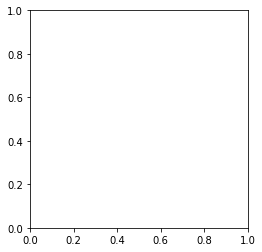

In [27]:
# a = np.array(landscape_qvm)
a = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.15, -0.3, -0.1, -0.1, -0.05, -0.1, -0.2, -0.15, 0.0, -0.4, -0.45, -0.4, -0.3, -0.55, -0.35, -0.45, -0.6, -0.55, -0.5, -0.5, -0.65, -0.85, -0.4, 0.05, -0.35, -0.25, -0.6, -0.05, -0.45, 0.45, -0.35, 0.55, -0.05, 0.9, -0.5, 1.1, -0.1, -0.2, -0.05, 0.5, 2.4, 1.65, 1.45, 2.45, 1.6, 1.45, 0.15, 2.85, 1.2, 4.35, 5.05, 3.7, 2.2, 3.15, 3.15, 4.4, 4.35, 4.55, 3.1, 8.0, 5.75, 4.4, 7.15, 6.75, 5.75, 6.8, 5.55, 6.8, 7.15, 8.0, 7.5, 8.0, 8.5, 8.0, 8.15, 6.95, 8.0, 8.0, 7.15, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5])

In [28]:
np.sort(a)

array([-0.85, -0.65, -0.6 , -0.6 , -0.55, -0.55, -0.5 , -0.5 , -0.5 ,
       -0.45, -0.45, -0.45, -0.4 , -0.4 , -0.4 , -0.35, -0.35, -0.35,
       -0.3 , -0.3 , -0.25, -0.2 , -0.2 , -0.15, -0.15, -0.1 , -0.1 ,
       -0.1 , -0.1 , -0.05, -0.05, -0.05, -0.05,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.05,  0.15,  0.45,  0.5 ,  0.55,  0.9 ,  1.1 ,  1.2 ,  1.45,
        1.45,  1.6 ,  1.65,  2.2 ,  2.4 ,  2.45,  2.85,  3.1 ,  3.15,
        3.15,  3.7 ,  4.35,  4.35,  4.4 ,  4.4 ,  4.55,  5.05,  5.55,
        5.75,  5.75,  6.75,  6.8 ,  6.8 ,  6.95,  7.15,  7.15,  7.15,
        7.5 ,  8.  ,  8.  ,  8.  ,  8.  ,  8.  ,  8.  ,  8.15,  8.5 ,
        8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,  8.5 ,
        8.5 ])

In [12]:
from pyquil import Program, noise
from pyquil.api import WavefunctionSimulator
from pyquil.gates import H
from pyquil.paulis import sZ, sX, sI, exponentiate_commuting_pauli_sum
from scipy.optimize import minimize

import operator
import matplotlib.pyplot as plt

In [ ]:
def mis_ansatz(betas, gammas):
    pq = Program()
    pq += [exponentiate_commuting_pauli_sum(h_cost)(g) + exponentiate_commuting_pauli_sum(h_driver)(b) 
                for g, b in zip(gammas, betas)]
    return pq

In [ ]:
def mis_cost(params):
    half = int(len(params)/2)
    betas, gammas = params[:half], params[half:]
    #init_state_prog = Program(RESET())
    #pq = init_state_prog + mis_ansatz(betas, gammas, h_cost, h_driver)
    pq = mis_ansatz(betas, gammas)
    return WavefunctionSimulator().expectation(prep_prog = pq, pauli_terms = h_cost)

In [ ]:
def run_qaoa_mis(guess):
    result = minimize(mis_cost, x0 = guess, method='Nelder-Mead', options={'disp': True})
    wf_sim = WavefunctionSimulator()
    half = int(len(result['x'])/2)
    pq = mis_ansatz(result['x'][:half],result['x'][half:])
    wavefunction = wf_sim.wavefunction(pq)
    prob_dict = wavefunction.get_outcome_probs() 
    sorted_dict = sorted(prob_dict.items(), key = operator.itemgetter(1))
    return sorted_dict[len(prob_dict)-1]

In [ ]:
# elist = [(1, 4), (1, 7), (1, 8), (1, 9), (1, 10), (2, 5), (2, 6), (2, 8), (3, 4), (3, 5),
#           (3, 7), (4, 7), (4, 10), (5, 6), (5, 9), (6, 7), (6, 9), (6, 10), (7, 9), (9, 10)]
#string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 7, 3 <-> 4, 3 <-> 7, 4 <-> 6, 4 <-> 7, 7 <-> 8'

string = '1 <-> 2, 1 <-> 3, 1 <-> 4, 1 <-> 5, 2 <-> 3, 2 <-> 4, 2 <-> 5, 3 <-> 4, 4 <-> 5'
elist = elist_from_math(string)

num_nodes = 5
delta = 1
U = 1.5
omega = 0.5

h_cost, h_driver = get_hamil(num_nodes, elist, 1, 1.5, 0.5)

In [ ]:
%%time
result = run_qaoa_mis([0.5,0.5, 0.5, 0.5])
print(result)

In [ ]:
# correct = '1011010000'
# correct = '10110110'
correct = '10100'
p_vals = []
prob_vals = []
for p in range(1,11):
    params = [0.5] * 2 * p
    result = run_qaoa_mis(params)
    if (result[0] == correct):
        p_vals.append(p)
        prob_vals.append(result[1])
    else:
        print("BAD p value:", p, "with State:", result[0])

In [78]:
p = Program(I(0), I(1))

In [80]:
program = Program(X(0), MEASURE(0, 0))
results = qvm.run(program)

/home/forest/.virtualenvs/venv/lib/python3.6/site-packages/pyquil/gates.py:490: UserWarning: Indexing measurement addresses by integers is deprecated. Replacing this with the MemoryReference ro[i] instead.
  + "Replacing this with the MemoryReference ro[i] instead.")


AssertionError: 

In [90]:
from pyquil.api import QVMConnection
qvm = QVMConnection()
program = Program(X(0), I(1))
program.measure_all()
results = qvm.run(program)

In [91]:
results

[[1, 0]]